# Simple GP Regression on EEG data

## Imports

In [7]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

import msc

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

picks: ('C3',)
Reading header...


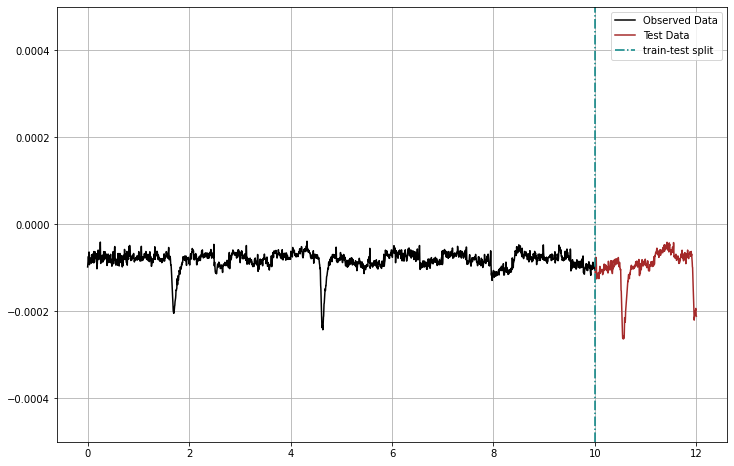

In [8]:
picks = msc.etl.PicksOptions.one_channel
dataset = msc.etl.load_tensor_dataset(picks=picks)
train_x = dataset.get("train_x")
train_y = dataset.get("train_y").squeeze()
test_x = dataset.get("test_x")
test_y = dataset.get("test_y").squeeze()
# plot training data
# Initialize plot
(f, ax), ymin, ymax = plt.subplots(1, 1, figsize=(12, 8)), -5e-4, 5e-4

# Plot training data as black stars
# ax.plot(np.r_[train_x.numpy(), test_x.numpy()], np.r_[train_y.numpy(), test_y.numpy()], 'k*', label='Observed Data')
ax.plot(train_x.numpy(), train_y.numpy(), 'black', label='Observed Data')
ax.plot(test_x.numpy(), test_y.numpy(), 'brown', label='Test Data')
ax.axvline(10, label='train-test split', color='teal', linestyle='-.')
ax.grid('both')
ax.set_ylim([ymin, ymax])
ax.legend()

## Initialize likelihood and model

In [9]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)


## Train

In [10]:
# this is for running the notebook in our testing framework
import os

smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()


C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\gpytorch\utils\linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ..\aten\src\ATen\native\Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)


Iter 1/50 - Loss: 0.749   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.712   lengthscale: 0.744   noise: 0.644
Iter 3/50 - Loss: 0.675   lengthscale: 0.798   noise: 0.598
Iter 4/50 - Loss: 0.636   lengthscale: 0.855   noise: 0.554
Iter 5/50 - Loss: 0.597   lengthscale: 0.913   noise: 0.513
Iter 6/50 - Loss: 0.556   lengthscale: 0.973   noise: 0.474
Iter 7/50 - Loss: 0.516   lengthscale: 1.035   noise: 0.437
Iter 8/50 - Loss: 0.474   lengthscale: 1.099   noise: 0.403
Iter 9/50 - Loss: 0.432   lengthscale: 1.165   noise: 0.370
Iter 10/50 - Loss: 0.389   lengthscale: 1.232   noise: 0.340
Iter 11/50 - Loss: 0.345   lengthscale: 1.301   noise: 0.312
Iter 12/50 - Loss: 0.301   lengthscale: 1.370   noise: 0.286
Iter 13/50 - Loss: 0.256   lengthscale: 1.441   noise: 0.261
Iter 14/50 - Loss: 0.211   lengthscale: 1.512   noise: 0.239
Iter 15/50 - Loss: 0.165   lengthscale: 1.584   noise: 0.218
Iter 16/50 - Loss: 0.119   lengthscale: 1.657   noise: 0.199
Iter 17/50 - Loss: 0.072   length

## Test

In [11]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    # test_x = torch.linspace(0, 12, 151)
    observed_pred = likelihood(model(torch.concat([train_x, test_x])))

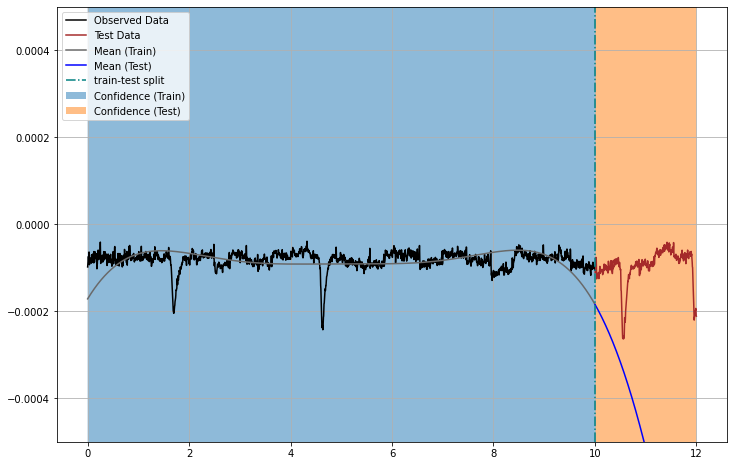

In [12]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    split_ix = len(train_x)
    train_lower, test_lower, train_upper, test_upper = lower[:split_ix], lower[split_ix:], upper[:split_ix], upper[split_ix:]
    # Plot training data
    ax.plot(train_x.numpy(), train_y.numpy(), 'black', label='Observed Data')
    # Plot testing data
    ax.plot(test_x.numpy(), test_y.numpy(), 'brown', label='Test Data')
    # Plot predictive means in train region
    ax.plot(train_x.numpy(), observed_pred[:split_ix].mean.numpy(), 'dimgray', label='Mean (Train)')
    # Plot predictive means in test region
    ax.plot(test_x.numpy(), observed_pred[split_ix:].mean.numpy(), 'b', label='Mean (Test)')
    # Shade between the lower and upper confidence bounds  (train)
    ax.fill_between(train_x.numpy(), train_lower.numpy(), train_upper.numpy(), alpha=0.5, label='Confidence (Train)')
    # Shade between the lower and upper confidence bounds  (test)
    ax.fill_between(test_x.numpy(), test_lower.numpy(), test_upper.numpy(), alpha=0.5, label='Confidence (Test)')
    ax.axvline(10, label='train-test split', color='teal', linestyle='-.')
    ax.grid('both')
    ax.legend()
    ax.set_ylim([ymin, ymax])